# A Python interface to PISA!

The [PISA Engine](https://github.com/pisa-engine/pisa) provides blazing-fast retrieval over sparse indices. This is helpful for all sorts of things, including initial candidate set generation for neural re-ranking.

Our inteface adheres with the [PyTerrier API](https://pyterrier.readthedocs.io/en/latest/), which makes it simple to combine PISA retrieval with loads of other tools.

To start using it, you can install it from the pypi `pyterrier_pisa` package.

In [ ]:
!pip install -q pyterrier-pisa

We'll first import everything that we'll need.

In [2]:
import pyterrier as pt
if not pt.started():
  pt.init()
from pyterrier_pisa import PisaIndex
from pyterrier.measures import *

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



`PisaIndex` is the main class for the interface. You can create an index just by passing in a file path. (It will create an index there if one doesn't yet exist.)

In [3]:
idx = PisaIndex('./my-index.pisa')

## Indexing

Indexing a dataset is easy. We'll use the [ANTIQUE dataset](https://arxiv.org/pdf/1905.08957.pdf) [1] as an example. It'll go ahead and download the source files as we need them. We could use any dataset from [ir-datasets](https://ir-datasets.com/), if we like. Or any iterator, the same way as [PyTerrier's indexer](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html#iterdictindexer).

[1] Hashemi, Helia et al. “ANTIQUE: A Non-factoid Question Answering Benchmark.” ECIR 2020. https://arxiv.org/abs/1905.08957

In [ ]:
dataset = pt.get_dataset('irds:antique/test')
idx.index(dataset.get_corpus_iter())

You can also use an index object as part of a larger indexing pipeline. For instance, if you want to perform doc2query expansion before indexing, you can build the following pipeline that makes use of the [pyterrier_doc2query](https://github.com/terrierteam/pyterrier_doc2query) package:

```python
index_pipeline = (
  # Get expansion terms
  Doc2Query(out_attr="exp_terms", batch_size=8) >>
  # Combine original text and expansion terms
  pt.apply.text(lambda r: r['text'] + ' ' + r['exp_terms']) >>
  # Pass resulting enriched documents to the index
  index)
index_pipeline.index(dataset.get_corpus_iter())
```

## Retrieval

Let's get to the good stuff -- retrieval! `PisaIndex` provides a variety of retrieval functions that can be accessed as follows:

```python
idx.bm25()
idx.dph()
idx.qld()
idx.pl2()
```

Each also accepts general retrieval parameters, like `num_results` (defaults to 1000) and model-specific parameters (e.g., BM25's `k1` and `b`)

```python
idx.bm25(num_results=10, k1=2.5, b=0.4)
```

In [5]:
bm25 = idx.bm25()

# You can now search the index!
bm25.search('pepsi cola')

qid       docno  rank      score       query
0    1      8529_3     1  21.111420  pepsi cola
0    1  2661278_17     2  20.443359  pepsi cola
0    1    542123_8     3  19.885399  pepsi cola
0    1   383571_17     4  19.458706  pepsi cola
0    1   542123_11     5  19.294403  pepsi cola
..  ..         ...   ...        ...         ...
0    1   2231266_2   371   2.241298  pepsi cola
0    1   1615170_2   372   2.052358  pepsi cola
0    1   4283189_3   373   1.895202  pepsi cola
0    1   2604148_2   374   1.864453  pepsi cola
0    1   3156659_6   375   1.809915  pepsi cola

[375 rows x 5 columns]

Because the PISA index adheres with the PyTerrier API, we can easily mix it with all sorts of other functionality. For instance, if we want to see the document text, we can use the [`get_text` transformer](https://pyterrier.readthedocs.io/en/latest/text.html#pyterrier.text.get_text):

In [6]:
(bm25 >> pt.text.get_text(dataset, 'text')).search('pepsi cola')

[INFO] [starting] building docstore
docs_iter: 100%|████████████████████| 403666/403666 [00:05<00:00, 72464.13doc/s]
[INFO] [finished] docs_iter: [00:05] [403666doc] [72452.81doc/s]
[INFO] [finished] building docstore [5.58s]


qid       docno  rank      score       query  \
0    1      8529_3     1  21.111420  pepsi cola   
0    1  2661278_17     2  20.443359  pepsi cola   
0    1    542123_8     3  19.885399  pepsi cola   
0    1   383571_17     4  19.458706  pepsi cola   
0    1   542123_11     5  19.294403  pepsi cola   
..  ..         ...   ...        ...         ...   
0    1   2231266_2   371   2.241298  pepsi cola   
0    1   1615170_2   372   2.052358  pepsi cola   
0    1   4283189_3   373   1.895202  pepsi cola   
0    1   2604148_2   374   1.864453  pepsi cola   
0    1   3156659_6   375   1.809915  pepsi cola   

                                                 text  
0   This is all what I found.. .  . . . ADS & HIST...  
0   Pepsi is a cola.. It's a hideously crappy cola...  
0           one is Pepsi Cola the others is Coke Cola  
0   of all cola's RC, but between pepsi and coke, ...  
0   Pepsi comes in a blue can and Coca Cola Comes ...  
..                                                ...  
0   it a global awareness proyect,as well as colle...  
0   try this . . Sleep tips and advice. . Do you l...  
0   "GET OUT OF BED: . . One of the most important...  
0   just try telling her how you dont eat cheese t...  
0   I'm really not sure, but I have recently recie...  

[375 rows x 6 columns]

From there, you can build re-ranking pipelines, e.g., using the monoT5 integration from the [pyterrier_t5](https://github.com/terrierteam/pyterrier_t5) package:

```python
monot5 = MonoT5ReRanker()
pipeline = bm25 >> pt.text.get_text(dataset, 'text') >> monot5
pipeline.search('pepsi cola')
```

We can also perform batch retrieval. The dataset provides the standard set of test topics for ANTIQUE:

In [7]:
topics = dataset.get_topics()
topics

[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: [00:00] [11.4kB] [2.33MB/s]


qid                                              query
0    3990512           how can we get concentration onsomething
1     714612  why doesn t the water fall off earth if it s r...
2    2528767  how do i determine the charge of the iron ion ...
3     821387      i have mice how do i get rid of them humanely
4    1880028   what does see leaflet mean on ept pregnancy test
..       ...                                                ...
195  2192891       how are braces put on and do they hurt a lot
196  4406669                     what do you order at taco bell
197  1582877  why do we go to school if in the real world we...
198  1340574  why do some people only go to church on easter...
199  1971899                                  what is masturbat

[200 rows x 2 columns]

In [8]:
# ... which we can then pass to the retrieval transformer to retrieve all of them
bm25(topics)

qid       docno  rank      score  \
0    3990512   4366141_0     1  10.219244   
0    3990512   3077638_1     2  10.022177   
0    3990512   882429_10     3   9.896416   
0    3990512   3553825_2     4   9.734148   
0    3990512   1173778_0     5   9.584581   
..       ...         ...   ...        ...   
198  1340574   3077672_0   996   7.844855   
198  1340574   2450218_2   997   7.839646   
198  1340574   1306039_3   998   7.838488   
198  1340574   3849385_4   999   7.834619   
198  1340574  2754370_13  1000   7.834619   

                                                 query  
0             how can we get concentration onsomething  
0             how can we get concentration onsomething  
0             how can we get concentration onsomething  
0             how can we get concentration onsomething  
0             how can we get concentration onsomething  
..                                                 ...  
198  why do some people only go to church on easter...  
198  why do some people only go to church on easter...  
198  why do some people only go to church on easter...  
198  why do some people only go to church on easter...  
198  why do some people only go to church on easter...  

[187968 rows x 5 columns]

## Evaluation and Experimentation

If we want to evaluate and compare approaches, we can use [pt.Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html):

In [9]:
pt.Experiment(
    [idx.bm25(), idx.dph(), idx.qld(), idx.pl2()],
    dataset.get_topics(),
    dataset.get_qrels(),
    [MAP(rel=3), MRR(rel=3), P(rel=3)@1, P(rel=3)@3, P(rel=3)@10, 'mrt']
)

[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel: [00:00] [150kB] [535kB/s]


name  AP(rel=3)  RR(rel=3)  \
0  PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...   0.242268   0.616153   
1  PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...   0.224329   0.614011   
2  PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...   0.190604   0.523148   
3  PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...   0.180212   0.475880   

   P(rel=3)@1  P(rel=3)@3  P(rel=3)@10       mrt  
0       0.495    0.411667       0.2955  1.058876  
1       0.490    0.403333       0.2740  1.398406  
2       0.400    0.321667       0.2420  1.382774  
3       0.315    0.285000       0.2260  1.754695

These results look good! In fact, the BM25 results are higher than those reported in the [ANTIQUE paper](https://arxiv.org/pdf/1905.08957.pdf). They also run really fast -- 1.1 to 1.8 ms per query (`mrt` above).

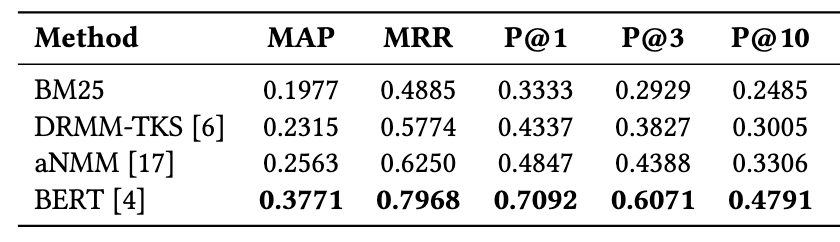